In [24]:
import os
import sys
sys.path.append('/home/kal/TF_models/bin/')
sys.path.append('/home/kal/K27act_models/convolution_model/')
sys.path.append('/home/kal/K27act_models/cg_model/')
sys.path.append('/home/thouis/basenji_embeddings')
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import tf_memory_limit
from zinb import ZINB
import seaborn as sns
import h5py
import matplotlib.pyplot as plt
from keras.utils import plot_model

import pandas as pd
import numpy as np
import itertools
import sequence
import ucscgenome
from tqdm import tqdm
import time
import datagen
import sequence
import helper
import viz_sequence
import pickle

from keras.models import Model, load_model
from keras.layers import Input, Dense, SpatialDropout1D, Conv1D, Lambda, Dropout, Activation
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from keras import backend as K
import tensorflow as tf

import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)

In [2]:
#load in the DNA
genome = ucscgenome.Genome('/home/kal/.ucscgenome/hg19.2bit')

In [3]:
# load in ATAC data
atac_path = '/home/kal/K27act_models/GM_data/ATAC/atac_average.hdf5'
atac = h5py.File(atac_path, 'r')

In [4]:
# load in preprocessed data
peaks_path = '/home/kal/K27act_models/GM_data/k27act_training_regions.bed'
peaks = pd.read_table(peaks_path, header=None)
#note we make the 'k27act' column the 'score' column for the correct training behavior
peaks.columns='chr start end name fold_change atac score nucs'.split() 

In [5]:
# facts about the data
num_training_samples = len(peaks[(peaks.chr != 'chr8')])
print('{} training samples'.format(num_training_samples))

num_testing_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 0)])
print('{} testing samples'.format(num_testing_samples))

num_validaiton_samples = len(peaks[(peaks.chr == 'chr8') & (peaks.index%2 == 1)])
print('{} validation samples'.format(num_validaiton_samples))

160363 training samples
3413 testing samples
3414 validation samples


In [25]:
# directory stuff
out_dir = '/home/kal/K27act_models/convolution_model/'
timestr = time.strftime("%Y%m%d_%H%M%S")
out_path = os.path.join(out_dir, timestr + '_counts_pwm')
os.makedirs(out_path)
# make a file system
weights_path = os.path.join(out_path, 'intermediate_weights')
os.makedirs(weights_path)
history_path = os.path.join(out_path, 'history')
os.makedirs(history_path)

In [26]:
# model's input
batch_size=32
seqs = Input(batch_shape=(batch_size, 1024, 5))
num_outputs=1

#build the model
def add_RC(x):
    RC = K.concatenate([x[:, ::-1, :1], x[:, ::-1, 1:][::-1]], axis=2)
    return K.concatenate([x, RC], axis=0)
def add_RC_shape(s):
    return 2*s[0], s[1], s[2]

add_rc = Lambda(add_RC, name='add_rc', output_shape=add_RC_shape)
conv = Conv1D(128, 32, name='conv_in')
dense = Dense(num_outputs)

def max_by_direction(x):
    forward_max = K.max(x[:x.shape[0]//2, :, :], axis=1)
    reverse_max = K.max(x[x.shape[0]//2:, ::-1, :], axis=1)
    return K.maximum(forward_max, reverse_max)
def max_by_direction_shape(s):
    return s[0]//2, 1

wide_scan = Conv1D(1, 128, use_bias=False, kernel_initializer='ones', trainable=False, name='wide_scan', padding='valid')
take_max = Lambda(max_by_direction, name='max_by_direciton', output_shape=max_by_direction_shape)

scan = take_max(wide_scan(dense(conv(add_rc(seqs)))))

predictions =  Activation('relu')(scan)


#pi_layer = Dense(num_outputs, activation='sigmoid', name='pi_dense')
#pi_max = Lambda(max_by_direction, name='pi_max_by_direciton', output_shape=max_by_direction_shape)
#pi_add_rc = Lambda(add_RC, name='pi_add_rc', output_shape=add_RC_shape)
#pi = pi_max(pi_layer(pi_add_rc(seqs)))
#zinb = ZINB(pi, theta_init=tf.zeros([1, num_outputs]))

model = Model(inputs=seqs, outputs=predictions)

#model.layers[-1].trainable_weights.extend([zinb.theta_variable,
#                                           *pi_layer.trainable_weights])

In [27]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (32, 1024, 5)             0         
_________________________________________________________________
add_rc (Lambda)              (64, 1024, 5)             0         
_________________________________________________________________
conv_in (Conv1D)             (64, 993, 128)            20608     
_________________________________________________________________
dense_3 (Dense)              (64, 993, 1)              129       
_________________________________________________________________
wide_scan (Conv1D)           (64, 866, 1)              128       
_________________________________________________________________
max_by_direciton (Lambda)    (32, 1)                   0         
_________________________________________________________________
activation_1 (Activation)    (32, 1)                   0         
Total para

In [28]:
from keras.optimizers import RMSprop, SGD, Adam

opt = RMSprop(lr=1e-5)
model.compile(optimizer=opt, loss='mean_squared_error') 

early_stop = EarlyStopping(monitor='val_loss', patience=100)
filepath = os.path.join(weights_path, 'weights-{epoch:02d}-{val_loss:.3f}.hdf5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

losses = model.fit_generator(datagen.batch_gen(peaks, mode='train', log=True), 
                             steps_per_epoch=num_training_samples//batch_size, 
                             epochs=20, callbacks=[early_stop, checkpoint], 
                             validation_data=datagen.batch_gen(peaks, mode='val', log=True), 
                             validation_steps=num_validaiton_samples//batch_size, verbose=2)




val_hist = losses.history['val_loss']
train_hist = losses.history['loss']

Epoch 1/20
 - 372s - loss: 1057.9577 - val_loss: 13.3427

Epoch 00001: val_loss improved from inf to 13.34270, saving model to /home/kal/K27act_models/convolution_model/20180709_152846_counts_pwm/intermediate_weights/weights-01-13.343.hdf5
Epoch 2/20
 - 375s - loss: 13.5521 - val_loss: 13.2669

Epoch 00002: val_loss improved from 13.34270 to 13.26686, saving model to /home/kal/K27act_models/convolution_model/20180709_152846_counts_pwm/intermediate_weights/weights-02-13.267.hdf5
Epoch 3/20
 - 377s - loss: 13.5055 - val_loss: 13.2589

Epoch 00003: val_loss improved from 13.26686 to 13.25894, saving model to /home/kal/K27act_models/convolution_model/20180709_152846_counts_pwm/intermediate_weights/weights-03-13.259.hdf5
Epoch 4/20
 - 376s - loss: 13.4000 - val_loss: 13.3178

Epoch 00004: val_loss did not improve from 13.25894
Epoch 5/20
 - 375s - loss: 13.3727 - val_loss: 13.3076

Epoch 00005: val_loss did not improve from 13.25894
Epoch 6/20
 - 378s - loss: 13.3826 - val_loss: 13.3035

Ep

In [21]:
# final save
model.save(os.path.join(out_path, 'final_model.h5'))

In [22]:
# write out history
pickle.dump(losses.history, open(os.path.join(history_path, 'history.pk'), 'wb'))

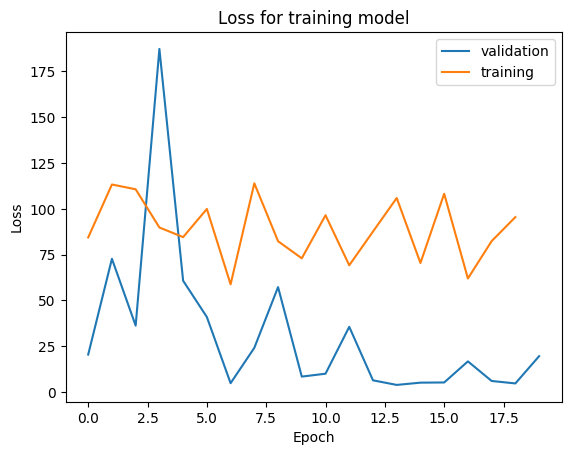

In [23]:
# look at loss
plt.plot(val_hist, label='validation')
plt.plot(train_hist[1:], label='training')
plt.title('Loss for training model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# look at kernels
model.summary()

# make a highlight map
from colour import Color

#what layers do we have to work with?
layer_dict = dict([(layer.name, layer) for layer in model.layers]) 
print(layer_dict.keys())
this_layer='conv_in'

# plot weights from first layer neurons
#temp = .005
weight_array = layer_dict[this_layer].get_weights()[0]
#create highlight dict - with sane maxs and mins
colors = list(Color("blue").range_to(Color("white"), 50))
[colors.append(c) for c in (Color("white").range_to(Color("red"), 51))]
top = np.amax(weight_array[:, 0, :])
bottom = np.amin(weight_array[:, 0, :])
    
# got throught the kernels
for idx in range(weight_array.shape[2]):
    weight = weight_array[:,:,idx]
    #get hightlights!
    color_weights = [int((x-bottom)/(top-bottom)*100) for x in weight[:,0]]
    highlight=dict()
    for i in range(len(weight)):
        w = color_weights[i]
        highlight[(colors[w].rgb[0],colors[w].rgb[1], colors[w].rgb[2], .3)] = [(i, i+1)]
    #plot things out
    kernel = sequence.Sequence(weight[:, 1:])
    plt.figure(figsize=(20,2))
    plt.title('ATAC weights and sequence for kernel {}'.format(idx))
    plt.plot(weight[:,0])
    plt.show()
    viz_sequence.plot_weights(kernel.seq, highlight=highlight)
